In [1]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from pmdarima import auto_arima
import datetime
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
%matplotlib inline
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw, pacf_ols 
from statsmodels.tsa.arima_model import ARIMA, ARMA, ARMAResults, ARIMAResults 
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from scipy.stats.stats import pearsonr
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse

In [2]:
# DAP

In [3]:
dap = pd.concat(map(pd.read_csv, ['C:/Users/abuka/Desktop/Baba_Desk/ABU_Project/Datasets/Day Ahead Power Price/Day-ahead Prices_201801010000-201901010000.csv',
                                 'C:/Users/abuka/Desktop/Baba_Desk/ABU_Project/Datasets/Day Ahead Power Price/Day-ahead Prices_201901010000-202001010000.csv',
                                 'C:/Users/abuka/Desktop/Baba_Desk/ABU_Project/Datasets/Day Ahead Power Price/Day-ahead Prices_202001010000-202101010000.csv']))

In [4]:
dap = dap.iloc[0:24218]

In [5]:
dap[['Start_date','End_date']] = dap['MTU (CET)'].str.split("-",expand=True,)
dap_df = pd.DataFrame(data=dap)
dap_df
dap_df['Start_date'] = pd.to_datetime(dap_df['Start_date'], utc=True, infer_datetime_format=True,dayfirst= True)
dap_df = dap_df.set_index('Start_date')
dap_df.drop(columns='MTU (CET)', inplace=True)
dap_df.drop(columns='End_date', inplace=True)

In [6]:
dap_df.isnull().values.sum()
dap_df = dap_df.apply(pd.to_numeric, errors='coerce')
dap_df = dap_df.interpolate(method ='linear',limit_direction ='both', axis = 0)
dap_df_new = dap_df.resample('D').mean().round(2)

In [7]:
dap_df_final = pd.DataFrame(dap_df_new['Day-ahead Price [EUR/MWh]'].loc['2019-01-01':'2020-10-05'])

In [8]:
dap_df_final

,Day-ahead Price [EUR/MWh]
Start_date,
2019-01-01 00:00:00+00:00,96.75
2019-01-02 00:00:00+00:00,121.41
2019-01-03 00:00:00+00:00,102.30
2019-01-04 00:00:00+00:00,112.85
2019-01-05 00:00:00+00:00,96.80
...,...
2020-10-01 00:00:00+00:00,82.64
2020-10-02 00:00:00+00:00,45.27
2020-10-03 00:00:00+00:00,45.94


In [9]:
# Demand

In [19]:
dem = pd.concat(map(pd.read_csv, ['C:/Users/abuka/Desktop/Baba_Desk/ABU_Project/Datasets/Demand data/Total Load - Day Ahead _ Actual_201901010000-202001010000.csv',
                                 'C:/Users/abuka/Desktop/Baba_Desk/ABU_Project/Datasets/Demand data/Total Load - Day Ahead _ Actual_202001010000-202101010000.csv']))

In [21]:
dem = dem.iloc[:30914]

In [22]:
dem_df = pd.DataFrame(data = dem)
dem_df.rename(columns={'Time (CET)':'MTU'},inplace=True)
dem_df.rename(columns={'Day-ahead Total Load Forecast [MW] - BZN|IE(SEM)':'Day_Ahead_Demand'},inplace=True)
dem_df.rename(columns={'Actual Total Load [MW] - BZN|IE(SEM)':'Actual_Load'},inplace=True)
dem_df[['Start_date','End_date']] = dem_df.MTU.str.split("-",expand=True,)
dem_df['Start_date'] = pd.to_datetime(dem_df['Start_date'], utc=True, infer_datetime_format=True,dayfirst= True)
dem_df = dem_df.set_index('Start_date')
dem_df.drop(columns={'MTU','End_date'}, inplace=True)
dem_df = dem_df.apply(pd.to_numeric, errors='coerce')

In [23]:
dem_df_new=dem_df
dem_df_new.isnull().values.sum()
dem_df_imp = dem_df_new.interpolate(method ='linear',limit_direction ='both', axis = 0)
dem_df_imp.isnull().sum()
# Resampling
dem_df_daily = dem_df_imp.resample('D').mean()

In [24]:
dem_df_final=pd.DataFrame(dem_df_daily['Day_Ahead_Demand'])

In [25]:
dem_df_final

,Day_Ahead_Demand
Start_date,
2019-01-01 00:00:00+00:00,4971.604167
2019-01-02 00:00:00+00:00,5114.312500
2019-01-03 00:00:00+00:00,4588.104167
2019-01-04 00:00:00+00:00,4552.604167
2019-01-05 00:00:00+00:00,4378.020833
...,...
2020-10-01 00:00:00+00:00,4512.187500
2020-10-02 00:00:00+00:00,4480.541667
2020-10-03 00:00:00+00:00,4112.833333


In [26]:
#Coal

In [27]:
wg = pd.concat(map(pd.read_csv, ['C:/Users/abuka/Desktop/Baba_Desk/ABU_Project/Datasets/Wind Generation/Actual Generation per Production Type_201901010000-202001010000.csv',
                                 'C:/Users/abuka/Desktop/Baba_Desk/ABU_Project/Datasets/Wind Generation/Actual Generation per Production Type_202001010000-202101010000.csv']))

In [28]:
wg=wg.drop(columns='Area')
wg['MTU'] = wg['MTU'].map(lambda x: x.rstrip(' (CET)'))
wg[['Start_date','End_date']] = wg.MTU.str.split("-",expand=True,)
wg_df = pd.DataFrame(data=wg)
wg_df = wg_df.iloc[:30914]
wg_df['Start_date'] = pd.to_datetime(wg_df['Start_date'], utc=True, infer_datetime_format=True,dayfirst= True)
wg_df = wg_df.set_index('Start_date')

In [29]:
wg_df.drop(columns={'MTU','End_date'}, inplace=True)
wg_df = wg_df.apply(pd.to_numeric, errors='coerce')
wg_df.dropna(how='all', axis=1,inplace=True)
wg_df.dropna(how='all', axis=1,inplace=True)
wg_df = wg_df.interpolate(method ='linear',limit_direction ='both', axis = 0)
wg_df_new = wg_df.resample('D').mean().round(2)


In [30]:
wg_coal_final= pd.DataFrame(wg_df_new['Fossil Hard coal  - Actual Aggregated [MW]'])
wg_coal_final.rename(columns={'Fossil Hard coal  - Actual Aggregated [MW]': 'Coal'},inplace=True)

In [31]:
wg_coal_final

,Coal
Start_date,
2019-01-01 00:00:00+00:00,87.98
2019-01-02 00:00:00+00:00,119.60
2019-01-03 00:00:00+00:00,107.75
2019-01-04 00:00:00+00:00,108.96
2019-01-05 00:00:00+00:00,126.46
...,...
2020-10-01 00:00:00+00:00,183.46
2020-10-02 00:00:00+00:00,86.71
2020-10-03 00:00:00+00:00,159.40


In [32]:
# Wind Onshore

In [33]:
wf = pd.concat(map(pd.read_csv, ['C:/Users/abuka/Desktop/Baba_Desk/ABU_Project/Datasets/Wind_Forecast/Generation Forecasts for Wind and Solar_201901010000-202001010000.csv',
                                 'C:/Users/abuka/Desktop/Baba_Desk/ABU_Project/Datasets/Wind_Forecast/Generation Forecasts for Wind and Solar_202001010000-202101010000.csv']))

In [34]:
wf_df = pd.DataFrame(data = wf)
wf_df = wf_df.iloc[:15457]
wf_df.rename(columns={'MTU (CET)':'MTU'},inplace=True)
wf_df[['Start_date','End_date']] = wf_df.MTU.str.split("-",expand=True,)
wf_df['Start_date'] = pd.to_datetime(wf_df['Start_date'], utc=True, infer_datetime_format=True, dayfirst= True)
wf_df = wf_df.set_index('Start_date')
wf_df.drop(columns={'MTU','End_date'})
wf_df = wf_df.apply(pd.to_numeric, errors='coerce')

In [35]:
# delete total null columns
wf_df.dropna(how='all', axis=1,inplace=True)
wf_df = wf_df.interpolate(method ='linear',limit_direction ='both', axis = 0)
wf_df.rename(columns={'Generation - Wind Onshore  [MW] Day Ahead/ BZN|IE(SEM)':'Wind_Onshore_Day_Ahead'}, inplace= True)
wf_df_final = wf_df.resample('D').mean().round(2)

In [36]:
wf_df_final

,Wind_Onshore_Day_Ahead
Start_date,
2019-01-01 00:00:00+00:00,244.62
2019-01-02 00:00:00+00:00,498.58
2019-01-03 00:00:00+00:00,764.29
2019-01-04 00:00:00+00:00,1133.38
2019-01-05 00:00:00+00:00,1362.71
...,...
2020-10-01 00:00:00+00:00,483.17
2020-10-02 00:00:00+00:00,1903.96
2020-10-03 00:00:00+00:00,869.38


In [37]:
# Final DF

In [38]:
final_df = pd.concat([dap_df_final,dem_df_final,wg_coal_final,wf_df_final],axis =1)

In [39]:
final_df.rename(columns={'Day-ahead Price [EUR/MWh]':'Day-Ahead Price'},inplace=True)
final_df.rename(columns={'Wind_Onshore_Day_Ahead':'Wind_Onshore'},inplace=True)

In [40]:
corr_df = final_df

In [41]:
corr_df = corr_df.reset_index()

In [77]:
# corr_df = corr_df.drop('Start_date', 1)

In [42]:
corr_df

,Start_date,Day-Ahead Price,Day_Ahead_Demand,Coal,Wind_Onshore
0,2019-01-01 00:00:00+00:00,96.75,4971.604167,87.98,244.62
1,2019-01-02 00:00:00+00:00,121.41,5114.312500,119.60,498.58
2,2019-01-03 00:00:00+00:00,102.30,4588.104167,107.75,764.29
3,2019-01-04 00:00:00+00:00,112.85,4552.604167,108.96,1133.38
4,2019-01-05 00:00:00+00:00,96.80,4378.020833,126.46,1362.71
...,...,...,...,...,...
639,2020-10-01 00:00:00+00:00,82.64,4512.187500,183.46,483.17
640,2020-10-02 00:00:00+00:00,45.27,4480.541667,86.71,1903.96
641,2020-10-03 00:00:00+00:00,45.94,4112.833333,159.40,869.38
642,2020-10-04 00:00:00+00:00,19.73,3910.458333,115.15,3125.42


In [43]:
corr = corr_df.corr(method='spearman')
print(corr)

                  Day-Ahead Price  Day_Ahead_Demand      Coal  Wind_Onshore
Day-Ahead Price          1.000000          0.092854  0.105293     -0.422829
Day_Ahead_Demand         0.092854          1.000000  0.235856      0.312582
Coal                     0.105293          0.235856  1.000000      0.002518
Wind_Onshore            -0.422829          0.312582  0.002518      1.000000


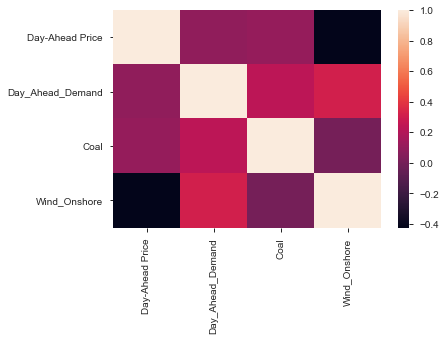

In [44]:
sns.heatmap(corr);

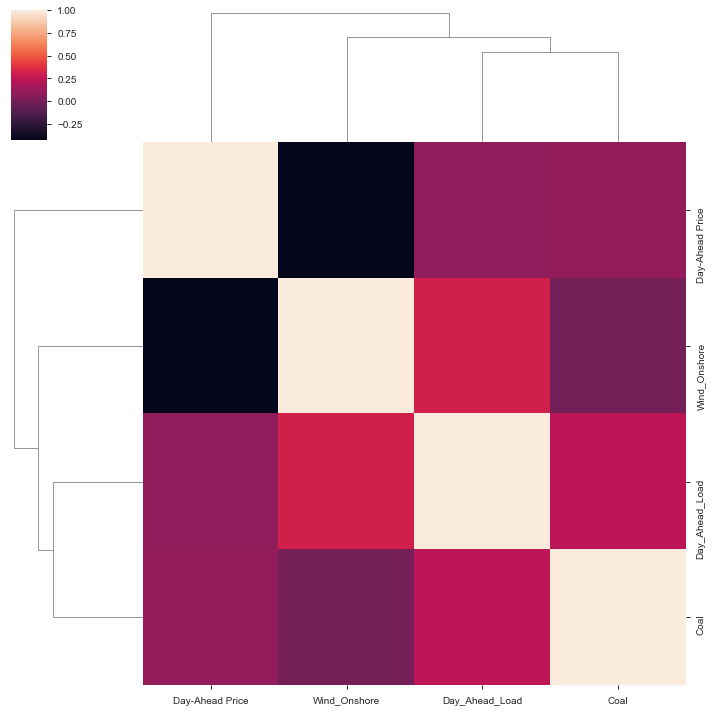

In [85]:
sns.clustermap(corr);

In [45]:
from statsmodels.tsa.api import VAR

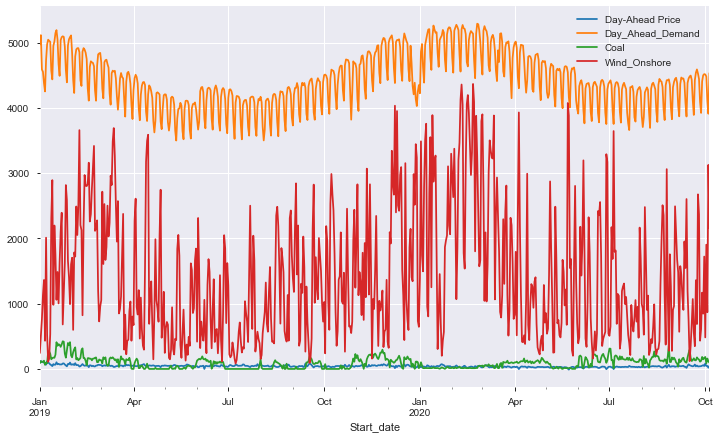

In [46]:
final_df.plot(figsize=(12,7));

In [48]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [49]:
adf_test(final_df['Day-Ahead Price'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -3.330315
p-value                   0.013577
# lags used              20.000000
# observations          623.000000
critical value (1%)      -3.440890
critical value (5%)      -2.866190
critical value (10%)     -2.569247
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [51]:
adf_test(final_df['Day_Ahead_Demand'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -1.690121
p-value                   0.436210
# lags used              20.000000
# observations          623.000000
critical value (1%)      -3.440890
critical value (5%)      -2.866190
critical value (10%)     -2.569247
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [52]:
adf_test(final_df['Coal'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -3.367868
p-value                   0.012104
# lags used               5.000000
# observations          638.000000
critical value (1%)      -3.440641
critical value (5%)      -2.866081
critical value (10%)     -2.569188
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [53]:
adf_test(final_df['Wind_Onshore'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -3.523963
p-value                   0.007393
# lags used              15.000000
# observations          628.000000
critical value (1%)      -3.440806
critical value (5%)      -2.866153
critical value (10%)     -2.569227
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [54]:
df_transformed = final_df.diff()

In [55]:
df_transformed = df_transformed.dropna()

In [56]:
adf_test(df_transformed['Day_Ahead_Demand'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -6.643000e+00
p-value                 5.351298e-09
# lags used             2.000000e+01
# observations          6.220000e+02
critical value (1%)    -3.440907e+00
critical value (5%)    -2.866198e+00
critical value (10%)   -2.569251e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [57]:
len(df_transformed)

643

In [58]:
nobs=5
train, test = df_transformed[0:-nobs], df_transformed[-nobs:]

In [59]:
print(train.shape)
print(test.shape)

(638, 4)
(5, 4)


In [ ]:
# VAR model order search

In [90]:
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]:
    model = VAR(train)
    results = model.fit(i)
    print('Order =', i)
    print('AIC: ', results.aic)
    print('BIC: ', results.bic)
    print()

Order = 1
AIC:  36.2430722309924
BIC:  36.38300220447975

Order = 2
AIC:  35.9042323735262
BIC:  36.1564134242813

Order = 3
AIC:  35.76826513081207
BIC:  36.13297142993399

Order = 4
AIC:  35.484848651894886
BIC:  35.96235547981559

Order = 5
AIC:  34.88220482825289
BIC:  35.472788580954486

Order = 6
AIC:  34.50461782684105
BIC:  35.20855602211745

Order = 7
AIC:  34.21532141756214
BIC:  35.03289270132566

Order = 8
AIC:  34.1711500331168
BIC:  35.10263418574997

Order = 9
AIC:  34.16451179388185
BIC:  35.210189736634895

Order = 10
AIC:  34.16014001020596
BIC:  35.320293811640326

Order = 11
AIC:  34.16459103427151
BIC:  35.43950391674986

Order = 12
AIC:  34.15238222960929
BIC:  35.54233857583232

Order = 13
AIC:  34.008023622824815
BIC:  35.513308982415396

Order = 14
AIC:  33.97740572867481
BIC:  35.59830682480979

Order = 15
AIC:  33.999785661744454
BIC:  35.73659039783456

Order = 16
AIC:  33.97761388598796
BIC:  35.830611352406265

Order = 17
AIC:  33.98185130867694
BIC:  35.9

In [116]:
auto_arima(final_df['Day-Ahead Price'],maxiter=1000)

ARIMA(maxiter=1000, method='lbfgs', order=(1, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=False)

In [117]:
auto_arima(final_df['Day_Ahead_Load'],maxiter=1000)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\s

ARIMA(maxiter=1000, method='lbfgs', order=(5, 1, 5), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=False)

In [119]:
auto_arima(final_df['Coal'],maxiter=1000)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\s

ARIMA(maxiter=1000, method='lbfgs', order=(3, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=False)

In [120]:
auto_arima(final_df['Wind_Onshore'],maxiter=1000)

ARIMA(maxiter=1000, method='lbfgs', order=(1, 1, 2), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=False)

In [91]:
model.endog_names

['Day-Ahead Price', 'Day_Ahead_Demand', 'Coal', 'Wind_Onshore']

In [92]:
# VAR Models 
results = model.fit(14)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 15, Dec, 2020
Time:                     13:56:00
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    35.5983
Nobs:                     624.000    HQIC:                   34.6073
Log likelihood:          -13914.6    FPE:                5.71593e+14
AIC:                      33.9774    Det(Omega_mle):     4.02937e+14
--------------------------------------------------------------------
Results for equation Day-Ahead Price
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                       -0.230993         0.383305           -0.603           0.547
L1.Day-Ahead Price          -0.679759         0.066076          -10.288           0.000
L1.Day_Ahead_Demand   

In [93]:
lag_order = results.k_ar
lag_order

14

In [94]:
z = results.forecast(y=train.values[-lag_order:], steps=5)
z

array([[-2.57220706e+00, -1.97381523e+01, -2.69840877e+01,
        -2.34892069e+02],
       [ 2.20869786e+00, -8.93547738e+01, -1.80451217e+01,
        -1.82892695e+02],
       [-1.59467956e+00, -3.44823288e+02, -6.71904294e+00,
        -1.41775249e+02],
       [-2.83710370e-01, -1.39403826e+02,  2.88462555e+01,
        -2.19851453e+02],
       [ 6.06006661e+00,  4.80173310e+02,  8.25939900e+00,
        -2.67709362e+01]])

In [95]:
test

,Day-Ahead Price,Day_Ahead_Demand,Coal,Wind_Onshore
Start_date,,,,
2020-10-01 00:00:00+00:00,37.70,-4.583333,15.29,-1238.00
2020-10-02 00:00:00+00:00,-37.37,-31.645833,-96.75,1420.79
2020-10-03 00:00:00+00:00,0.67,-367.708333,72.69,-1034.58
2020-10-04 00:00:00+00:00,-26.21,-202.375000,-44.25,2256.04
2020-10-05 00:00:00+00:00,25.74,621.562500,-18.65,-970.25


In [96]:
idx = pd.date_range('10/1/2020 00:00+00:00', periods=5, freq='D')
df_forecast = pd.DataFrame(z, index=idx, columns=['Day-Ahead Price_1d','Day_Ahead_Demand_1d','Coal_1d','Wind_Onshore_1d'])
df_forecast

,Day-Ahead Price_1d,Day_Ahead_Demand_1d,Coal_1d,Wind_Onshore_1d
2020-10-01 00:00:00+00:00,-2.572207,-19.738152,-26.984088,-234.892069
2020-10-02 00:00:00+00:00,2.208698,-89.354774,-18.045122,-182.892695
2020-10-03 00:00:00+00:00,-1.594680,-344.823288,-6.719043,-141.775249
2020-10-04 00:00:00+00:00,-0.283710,-139.403826,28.846256,-219.851453
2020-10-05 00:00:00+00:00,6.060067,480.173310,8.259399,-26.770936


In [103]:
# Now build the forecast values from the first difference set
df_forecast['Day-Ahead Price_forecast'] = final_df['Day-Ahead Price'].iloc[-nobs-1] + df_forecast['Day-Ahead Price_1d'].cumsum()

df_forecast['Day_Ahead_Demand_Prediction'] = final_df['Day_Ahead_Demand'].iloc[-nobs-1] + df_forecast['Day_Ahead_Demand_1d'].cumsum()

df_forecast['Coal_forecast'] = final_df['Coal'].iloc[-nobs-1] + df_forecast['Coal_1d'].cumsum()

df_forecast['Wind_Onshore_forecast'] = final_df['Wind_Onshore'].iloc[-nobs-1] + df_forecast['Wind_Onshore_1d'].cumsum()

In [98]:
df_forecast

,Day-Ahead Price_1d,Day_Ahead_Demand_1d,Coal_1d,Wind_Onshore_1d,Day-Ahead Price_forecast,Day_Ahead_Demand_forecast,Coal_forecast,Wind_Onshore_forecast
2020-10-01 00:00:00+00:00,-2.572207,-19.738152,-26.984088,-234.892069,42.367793,4497.032681,141.185912,1486.277931
2020-10-02 00:00:00+00:00,2.208698,-89.354774,-18.045122,-182.892695,44.576491,4407.677907,123.140791,1303.385236
2020-10-03 00:00:00+00:00,-1.594680,-344.823288,-6.719043,-141.775249,42.981811,4062.854619,116.421748,1161.609987
2020-10-04 00:00:00+00:00,-0.283710,-139.403826,28.846256,-219.851453,42.698101,3923.450793,145.268003,941.758534
2020-10-05 00:00:00+00:00,6.060067,480.173310,8.259399,-26.770936,48.758167,4403.624103,153.527402,914.987598


In [99]:
final_df[-5:]

,Day-Ahead Price,Day_Ahead_Demand,Coal,Wind_Onshore
Start_date,,,,
2020-10-01 00:00:00+00:00,82.64,4512.187500,183.46,483.17
2020-10-02 00:00:00+00:00,45.27,4480.541667,86.71,1903.96
2020-10-03 00:00:00+00:00,45.94,4112.833333,159.40,869.38
2020-10-04 00:00:00+00:00,19.73,3910.458333,115.15,3125.42
2020-10-05 00:00:00+00:00,45.47,4532.020833,96.50,2155.17


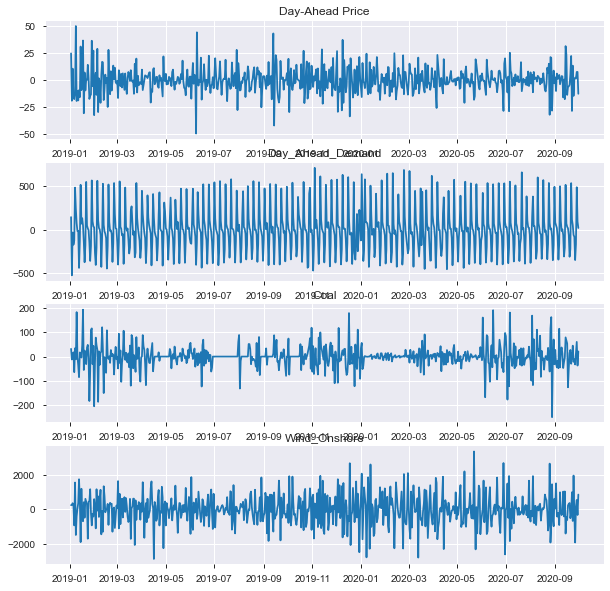

In [80]:
results.plot();

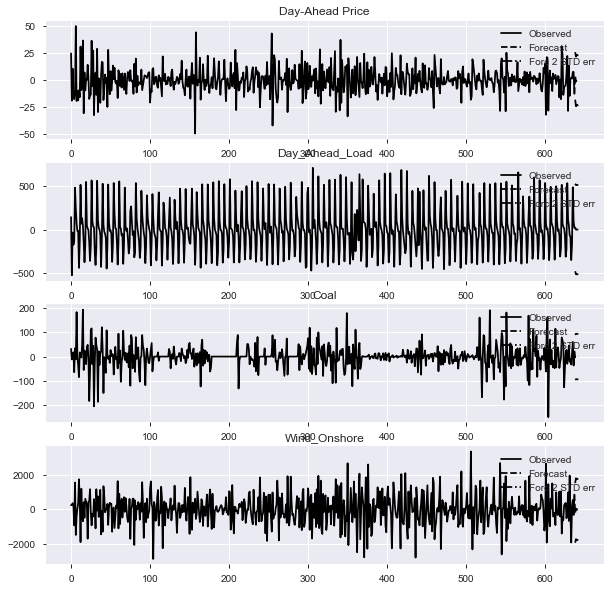

In [146]:
results.plot_forecast(5);

In [216]:
# Lag = 14
# RMSE1 = rmse(final_df['Day-Ahead Price'][-nobs:], df_forecast['Day-Ahead Price_forecast'])
# print(f'Day-Ahead Price VAR(1) RMSE: {RMSE1:.3f}')
# RMSE2 = rmse(final_df['Day_Ahead_Load'][-nobs:], df_forecast['Day_Ahead_Load_forecast'])
# print(f'Day_Ahead_Load VAR(1) RMSE: {RMSE2:.3f}')
# RMSE3 = rmse(final_df['Coal'][-nobs:], df_forecast['Coal_forecast'])
# print(f'Coal VAR(1) RMSE: {RMSE3:.3f}')
# RMSE4 = rmse(final_df['Wind_Onshore'][-nobs:], df_forecast['Wind_Onshore_forecast'])
# print(f'Wind_OnshoreVAR(1) RMSE: {RMSE4:.3f}')

Day-Ahead Price VAR(1) RMSE: 20.830
Day_Ahead_Load VAR(1) RMSE: 70.273
Coal VAR(1) RMSE: 42.710
Wind_OnshoreVAR(1) RMSE: 1245.692


In [100]:
RMSE1 = rmse(final_df['Day-Ahead Price'][-nobs:], df_forecast['Day-Ahead Price_forecast'])
print(f'Day-Ahead Price VAR(1) RMSE: {RMSE1:.3f}')
RMSE2 = rmse(final_df['Day_Ahead_Demand'][-nobs:], df_forecast['Day_Ahead_Demand_forecast'])
print(f'Day_Ahead_Demand VAR(1) RMSE: {RMSE2:.3f}')
RMSE3 = rmse(final_df['Coal'][-nobs:], df_forecast['Coal_forecast'])
print(f'Coal VAR(1) RMSE: {RMSE3:.3f}')
RMSE4 = rmse(final_df['Wind_Onshore'][-nobs:], df_forecast['Wind_Onshore_forecast'])
print(f'Wind_OnshoreVAR(1) RMSE: {RMSE4:.3f}')

Day-Ahead Price VAR(1) RMSE: 20.830
Day_Ahead_Demand VAR(1) RMSE: 70.273
Coal VAR(1) RMSE: 42.710
Wind_OnshoreVAR(1) RMSE: 1245.692


In [87]:
final_df

,Day-Ahead Price,Day_Ahead_Demand,Coal,Wind_Onshore
Start_date,,,,
2019-01-01 00:00:00+00:00,96.75,4971.604167,87.98,244.62
2019-01-02 00:00:00+00:00,121.41,5114.312500,119.60,498.58
2019-01-03 00:00:00+00:00,102.30,4588.104167,107.75,764.29
2019-01-04 00:00:00+00:00,112.85,4552.604167,108.96,1133.38
2019-01-05 00:00:00+00:00,96.80,4378.020833,126.46,1362.71
...,...,...,...,...
2020-10-01 00:00:00+00:00,82.64,4512.187500,183.46,483.17
2020-10-02 00:00:00+00:00,45.27,4480.541667,86.71,1903.96
2020-10-03 00:00:00+00:00,45.94,4112.833333,159.40,869.38


In [88]:
df_forecast

,Day-Ahead Price_1d,Day_Ahead_Demand_1d,Coal_1d,Wind_Onshore_1d,Day-Ahead Price_forecast,Day_Ahead_Demand_forecast,Coal_forecast,Wind_Onshore_forecast
2020-10-01 00:00:00+00:00,-2.572207,-19.738152,-26.984088,-234.892069,42.367793,4497.032681,141.185912,1486.277931
2020-10-02 00:00:00+00:00,2.208698,-89.354774,-18.045122,-182.892695,44.576491,4407.677907,123.140791,1303.385236
2020-10-03 00:00:00+00:00,-1.594680,-344.823288,-6.719043,-141.775249,42.981811,4062.854619,116.421748,1161.609987
2020-10-04 00:00:00+00:00,-0.283710,-139.403826,28.846256,-219.851453,42.698101,3923.450793,145.268003,941.758534
2020-10-05 00:00:00+00:00,6.060067,480.173310,8.259399,-26.770936,48.758167,4403.624103,153.527402,914.987598


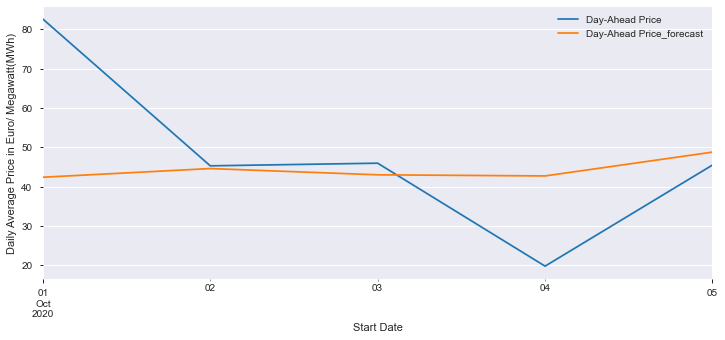

In [101]:
final_df['Day-Ahead Price'][-nobs:][-nobs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
df_forecast['Day-Ahead Price_forecast'].plot(legend=True,xlabel='Start Date', ylabel= 'Daily Average Price in Euro/ Megawatt(MWh)');

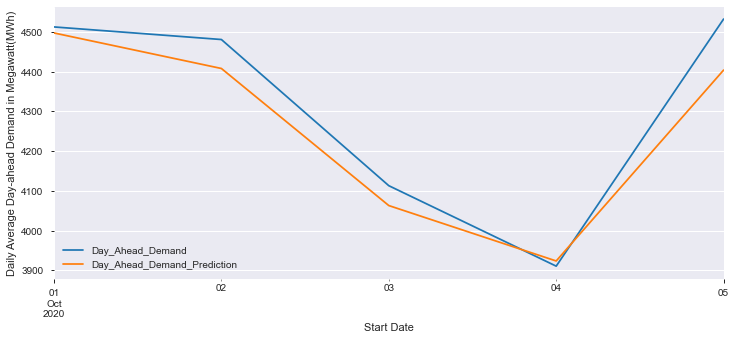

In [104]:
final_df['Day_Ahead_Demand'][-nobs:][-nobs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
df_forecast['Day_Ahead_Demand_Prediction'].plot(legend=True,xlabel='Start Date', ylabel= 'Daily Average Day-ahead Demand in Megawatt(MWh)');

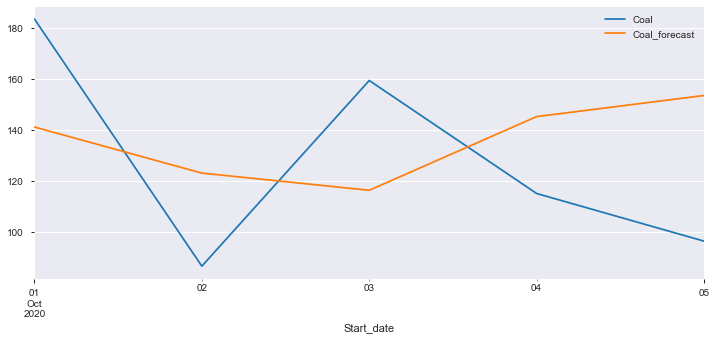

In [85]:
final_df['Coal'][-nobs:][-nobs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
df_forecast['Coal_forecast'].plot(legend=True);

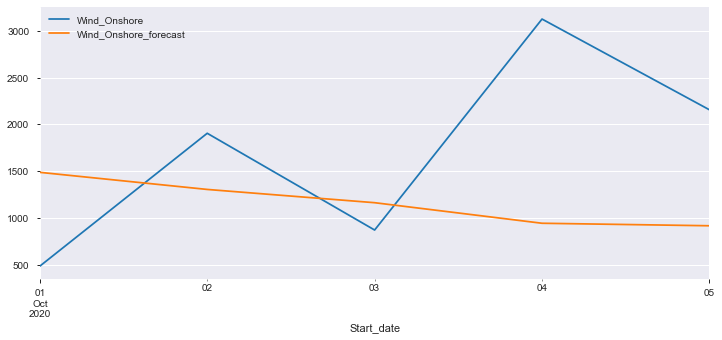

In [86]:
final_df['Wind_Onshore'][-nobs:][-nobs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
df_forecast['Wind_Onshore_forecast'].plot(legend=True);

In [ ]:
## log method

In [174]:
#Transform the columns using natural log
transformed_df['Day-Ahead Price_tran']=np.log(final_df['Day-Ahead Price'])
transformed_df['Day_Ahead_Load_tran']=np.log(final_df['Day_Ahead_Load'])
transformed_df['Coal_tran']=np.log(final_df['Coal'])
transformed_df['Wind_Onshore_tran']=np.log(final_df['Wind_Onshore'])


C:\Users\abuka\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\abuka\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [180]:
# Difference the data by 1 day
n=1
transformed_df['Day-Ahead Price_tran_diff'] = transformed_df['Day-Ahead Price_tran'] - transformed_df['Day-Ahead Price_tran'].shift(n)
transformed_df['Day_Ahead_Load_tran_diff'] = transformed_df['Day_Ahead_Load_tran'] - transformed_df['Day_Ahead_Load_tran'].shift(n)
transformed_df['Coal_tran_diff'] = transformed_df['Coal_tran'] - transformed_df['Coal_tran'].shift(n)
transformed_df['Wind_Onshore_tran_diff'] = transformed_df['Wind_Onshore_tran'] - transformed_df['Wind_Onshore_tran'].shift(n)


In [172]:
transformed_df = pd.DataFrame()

In [186]:
transformed_df

,Day-Ahead Price_tran,Day_Ahead_Load_tran,Coal_tran,Wind_Onshore_tran,Day-Ahead Price_tran_diff,Day_Ahead_Load_tran_diff,Coal_tran_diff,Wind_Onshore_tran_diff
Start_date,,,,,,,,
2019-01-01 00:00:00+00:00,4.572130,8.511498,4.477110,5.499706,NaN,NaN,NaN,NaN
2019-01-02 00:00:00+00:00,4.799173,8.539798,4.784153,6.211764,0.227043,0.028300,0.307043,0.712058
2019-01-03 00:00:00+00:00,4.627910,8.431222,4.679814,6.638947,-0.171264,-0.108576,-0.104339,0.427183
2019-01-04 00:00:00+00:00,4.726060,8.423455,4.690981,7.032960,0.098150,-0.007767,0.011167,0.394012
2019-01-05 00:00:00+00:00,4.572647,8.384352,4.839926,7.217231,-0.153413,-0.039103,0.148945,0.184271
...,...,...,...,...,...,...,...,...
2020-10-01 00:00:00+00:00,4.414494,8.414537,5.211997,6.180369,0.609166,-0.001015,0.087021,-1.270391
2020-10-02 00:00:00+00:00,3.812645,8.407499,4.462569,7.551691,-0.601849,-0.007038,-0.749427,1.371323
2020-10-03 00:00:00+00:00,3.827336,8.321867,5.071417,6.767780,0.014692,-0.085632,0.608848,-0.783911


In [192]:
# adfuller(transformed_df['Day-Ahead Price_tran'])

In [191]:
def augmented_dickey_fuller_statistics(time_series):
    """
    Run the augmented Dickey-Fuller test on a time series
    to determine if it's stationary.
    Arguments: 
        time_series: series. Time series that we want to test 
    Outputs: 
        Test statistics for the Augmented Dickey Fuller test in 
        the console 
    """
    result = adfuller(time_series.values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value)) 

In [218]:
# # print('Augmented Dickey-Fuller Test: Electricity Price Time Series')
# augmented_dickey_fuller_statistics(transformed_df['Day-Ahead Price_tran_diff'].dropna())

In [197]:
transformed_df.isnull().sum()

Day-Ahead Price_tran          4
Day_Ahead_Load_tran           0
Coal_tran                     0
Wind_Onshore_tran             0
Day-Ahead Price_tran_diff     9
Day_Ahead_Load_tran_diff      1
Coal_tran_diff               94
Wind_Onshore_tran_diff        1
dtype: int64